<a href="https://colab.research.google.com/github/BlinkovYevhenGit/CE888_Repository/blob/main/Assignment%202/Assignment2_DSDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Usage of TweetEval and Twitter-specific RoBERTa models

In this notebook we show how to perform tasks such as masked language modeling, computing tweet similarity or tweet classificationo using our Twitter-specific RoBERTa models.

- Paper: [_TweetEval_ benchmark (Findings of EMNLP 2020)](https://arxiv.org/pdf/2010.12421.pdf)
- Authors: Francesco Barbieri, Jose Camacho-Collados, Luis Espinosa-Anke and Leonardo Neves.
- [Github](https://github.com/cardiffnlp/tweeteval)


## Preliminaries

We define a function to normalize a tweet to the format we used for TweetEval. Note that preprocessing is minimal (replacing user names by `@user` and links by `http`).

In [55]:
!pip install unidecode
!pip install gensim
!pip install flashtext
!pip install transformers
!pip install pywaffle
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [56]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import os
from scipy.special import softmax
import csv
import urllib.request
from IPython.display import clear_output
from sklearn.metrics import recall_score, f1_score, get_scorer
import nltk
import random
import string
import pandas as pd
import seaborn as sns
import en_core_web_sm
from nltk.stem import WordNetLemmatizer
import re
from spacy.lang.en.stop_words import STOP_WORDS
stop_words = STOP_WORDS #a list of stop-words frequently encountered in usual texts
import matplotlib.pyplot as plt
import spacy
from pywaffle import Waffle
from flashtext import KeywordProcessor
import unidecode
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import datetime
import time
import collections
nltk.download('wordnet')
nltk.download('punkt')
stemmer = WordNetLemmatizer() # initialisation of a lemmatiser that detaches lemmas from words
digits = string.digits  #a list of digits from 0 to 9
verbose=1
chars = re.escape(string.punctuation)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
def remove_url_symbols(tweet):
  tweet_list= []
  for t in tweet.split():
      t=re.sub("@user|http.+","",t)
      # t = '' if t.startswith('@') and len(t) > 1 else t
      # t = '' if t.startswith('http') else t
      if t!="":
        tweet_list.append(t.strip())
  return " ".join(tweet_list), ["texts"]

In [58]:
def remove_stop_words(tweet):
  new_text=[]
  for word in tweet.split():
    if any(map(str.isdigit, word)) or word in STOP_WORDS: 
      pass    
    else:
      new_text.append(word)
  return " ".join(new_text), ["texts"]

In [59]:
def lemmatise_words(tweet):    
    #Lemmatisation of words
    new_text=[]
    for word in tweet.split(" "):
      word=stemmer.lemmatize(word)
      new_text.append(word)
    return " ".join(new_text), ["texts"]

In [60]:
def tweet_normalisation(tweet):
  tweet=tweet.lower()
  words_list=re.sub("["+chars+"“”‘]"," ",tweet).split(" ")
  words_list = [item for item in words_list if item != '']
  return " ".join(words_list), ["texts"]

In [61]:
def keywords_selection(tweet):
    print(gram_dict)
    print("Extracting keywords from texts using Pointwise Mutual Information method and TextRank")
    text_rank_key_words = dict()
    for i in range(0, len(table_to_process)):
        sentences = table_to_process.loc[i, "pr_abstract"]
        if sentences != None:
            keywords = get_keywords_by_textrank(sentences)
            if keywords != None:
                text_rank_key_words.update(keywords)
                print("Text", i, "- Done")

    for keyword in gram_dict.keys():
        parts = keyword.split()
        parts = "_".join(parts)
        keyword_processor.add_keyword(keyword, parts)

    for keyword in text_rank_key_words.keys():
        parts = keyword.split()
        parts = "_".join(parts)
        textrank_keyword_processor.add_keyword(keyword, parts)

    print(len(keyword_processor.get_all_keywords()))
    print(len(textrank_keyword_processor.get_all_keywords()))
    print(len(text_rank_key_words))

    table_to_process["pr_abstract"] = table_to_process["pr_abstract"].apply( lambda x: merge_two_keywords_methods(x, textrank_keyword_processor, keyword_processor))

In [62]:
def run_text_preprocessing_experiments(X_test, Y_test, y_true, tokeniser, model, labels, mapping, metric, experiments): 
  # for experiment in experiments: 
    X_test = data_preprocessing(X_test, experiments)
    y_pred = classify_many(X_test, tokeniser, model, labels)
    demonstrate_classification_results(X_test, Y_test, y_pred, mapping)
    calculate_accuracy_metrics(y_pred, y_true, metric)
    return X_test


In [63]:
def data_preprocessing(texts, sequence):
  actions = {
      # Data loading
      "Removal of URL symbols": { "function":lambda texts: apply_preprocessing_method(texts, lambda x: remove_url_symbols(x)), "resources":["texts"]}, #Returns texts, Requires text
      # Text normalisation
      "Text normalisation": {"function":lambda texts: apply_preprocessing_method(texts, lambda x: tweet_normalisation(x)),"resources":["texts"]}, #Returns texts, Requires text
      # Removing stop-words
      "Removal of stop-words": {"function":lambda texts: apply_preprocessing_method(texts, lambda x: remove_stop_words(x)),"resources":["texts"]}, #Returns texts, Requires text
      # Text lemmatisation
      "Text lemmatisation": {"function":lambda texts: apply_preprocessing_method(texts, lambda x: lemmatise_words(x)) ,"resources":["texts"]} #Returns texts, Requires text
  }
  print("Attempting pre-processing...")
  available_resources=dict()
  available_resources["texts"]=texts
  for action in sequence:
      func = actions[action]["function"]
      resources = actions[action]["resources"]
      missing_params=[]
      try:
          parameters = [available_resources[resource] if resource in available_resources else missing_params.append(resource) for resource in resources]
      except:
          print("There are not enough parameters to call the function", action, "!")
          print("Missing parameters: ",missing_params)
          return
      val1,context = func(*parameters)
      available_resources[context[0]] = val1
  return available_resources["texts"]


In [64]:
def apply_preprocessing_method(X_test, method, *kwargs):
  processed_texts=[]
  for text in X_test:
    processed_text, context = method(text,*kwargs)
    processed_texts.append(processed_text)
  return processed_texts, context

In [65]:
def load_all_data():
  tasks_data={
    "sentiment":{
        "metric":          lambda y_true,y_pred : recall_score(y_true=y_true,y_pred=y_pred, average="macro"),
        "model":           TFAutoModelForSequenceClassification.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment"),
        "tokeniser":       AutoTokenizer.from_pretrained(f"cardiffnlp/twitter-roberta-base-sentiment"),
        "X_test":          load_data(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt", is_csv=False),
        "Y_test":          load_data(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt", is_csv=False),
        "labels":          download_labels(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt")
    },
    "emotion":{
        "metric":          lambda y_true,y_pred : f1_score(y_true=y_true,y_pred=y_pred, average="macro"),
        "model":           TFAutoModelForSequenceClassification.from_pretrained(f"cardiffnlp/twitter-roberta-base-emotion"),
        "tokeniser":       AutoTokenizer.from_pretrained(f"cardiffnlp/twitter-roberta-base-emotion"),
        "X_test":          load_data(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_text.txt", is_csv=False),
        "Y_test":          load_data(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/test_labels.txt", is_csv=False),
        "labels":          download_labels(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emotion/mapping.txt")
    },
    "emoji":{
        "metric":          lambda y_true,y_pred : f1_score(y_true=y_true,y_pred=y_pred, average="macro"),
        "model":           TFAutoModelForSequenceClassification.from_pretrained(f"cardiffnlp/twitter-roberta-base-emoji"),
        "tokeniser":       AutoTokenizer.from_pretrained(f"cardiffnlp/twitter-roberta-base-emoji"),
        "X_test":          load_data(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/test_text.txt", is_csv=False),
        "Y_test":          load_data(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/test_labels.txt", is_csv=False),
        "labels":          download_labels(f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/emoji/mapping.txt")
    }
  
  }
  return tasks_data

In [66]:
def classify_many(xtexts,  tokenizer, model, labels):
  ypred=[]
  text_num=0
  for text in xtexts:
    # text_num+=1
    # print("Analysing",text_num,"- text from",len(xtexts))
    encoded_input = tokenizer(text, return_tensors='tf')
    output = model(encoded_input)
    scores = output[0][0].numpy()
    scores = softmax(scores)
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    l = labels[ranking[0]]
    # s = scores[ranking[0]]
    ypred.append(l)
    # clear_output(wait=True)
    # print(f"{1} {l} {np.round(float(s), 4)}")
  return ypred

In [67]:
def get_words_corpus(X_test):
    words_corpus = []
    for i in range(0, len(X_test)):
        words_corpus.extend(X_test[i].split())
    return words_corpus

In [68]:
def download_labels(mapping_link):
  # download label mapping
    csvreader = load_data(mapping_link, is_csv=True)
    labels = [row[1] for row in csvreader if len(row) > 1]
    return labels

In [69]:
def load_data(link, is_csv=False):
  with urllib.request.urlopen(link) as f:
    html = f.read().decode('utf-8').split("\n")
    if is_csv:
       csvreader = csv.reader(html, delimiter='\t')
       return csvreader
    return html

In [70]:
def apply_keywords_method(text, frequent_key_words_processor):
    frequent_key_words_version,words_list = extract_keywords(text,frequent_key_words_processor)
    return frequent_key_words_version,words_list


In [71]:
# In[11]:
def extract_keywords(text,keyword_processor):
    sentences=None
    if text==None:
        return None
    keywords_found = keyword_processor.extract_keywords(text)
    return " ".join(keywords_found),keywords_found

In [72]:
def demonstrate_classification_results(X_test, Y_test, y_pred, mapping):
  for i in range(10):
    print(i,"Predicted - ", y_pred[i], ", Expected - ", mapping[Y_test[i]])
  print()
  print("Tweet:")
  print(X_test[0])
  print("Result:")
  print(1,"Predicted - ", y_pred[0], ", Expected - ", mapping[Y_test[0]])
  print()

In [73]:
def calculate_accuracy_metrics(y_pred, y_true, metric):
    print("Calculating accuracy metric")
    print("Metric value:", metric(y_true,y_pred))
    print()


In [74]:
def run_programe(task, experiments):
  tasks_data=load_all_data()
  number_of_tweets=300
  print(len(tasks_data))
  X_test=tasks_data[task]["X_test"][:number_of_tweets]
  Y_test=tasks_data[task]["Y_test"][:number_of_tweets]

  tokeniser=tasks_data[task]["tokeniser"]
  model=tasks_data[task]["model"]
  labels=tasks_data[task]["labels"]
  metric=tasks_data[task]["metric"]

  mapping={str(key):value for key,value in enumerate(labels)}
  y_true=[mapping[Y_test[i]] for i in range(number_of_tweets)]

  y_pred = classify_many(X_test, tokeniser, model, labels)
  
  demonstrate_classification_results(X_test, Y_test, y_pred, mapping)

  calculate_accuracy_metrics(y_pred, y_true, metric)

  run_text_preprocessing_experiments(X_test, Y_test, y_true, tokeniser, model, labels, mapping, metric,experiments)


We only need to install one dependnecy: the `transformers` library.

## Use TweetEval Classifiers

We currently provide the following fine-tuned models for different tweet classification tasks:

- emoji prediction (`emoji`)
- emotion detection (`emotion`)
- hate speech detection (`hate`)
- irony detection (`irony`)
- offensive language identification (`offensive`)
- sentiment analysis (`sentiment`)
- _(coming soon)_ stance detection (`stance`) with 5 targets (`abortion`, `atheism`, `climate`, `feminist`, `hillary`), for example: `stance-abortion`


In [75]:
run_programe("sentiment",["Removal of URL symbols", "Text normalisation", "Removal of stop-words", "Text lemmatisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  neutral , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  neutral , Expected -  neutral
3 Predicted -  neutral , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted - 

In [76]:
run_programe("sentiment",["Removal of URL symbols", "Text normalisation", "Removal of stop-words"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  neutral , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  neutral , Expected -  neutral
3 Predicted -  neutral , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted - 

In [77]:
run_programe("sentiment",["Removal of URL symbols", "Text normalisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  negative , Expected -  negative
5 Predicted -  neutral , Expected -  neutral
6 Predicted

In [78]:
run_programe("sentiment",["Removal of URL symbols" ])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted

In [79]:
run_programe("sentiment", [])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted

In [80]:
run_programe("emotion",["Removal of URL symbols", "Text normalisation", "Removal of stop-words", "Text lemmatisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  anger , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  joy , Expected -  anger
6 Predicted -  sadness , Expected -

In [81]:
run_programe("emotion",["Removal of URL symbols", "Text normalisation", "Removal of stop-words"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  anger , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  joy , Expected -  anger
6 Predicted -  sadness , Expected -

In [82]:
run_programe("emotion",["Removal of URL symbols", "Text normalisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  anger , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected

In [83]:
run_programe("emotion",["Removal of URL symbols" ])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expec

In [84]:
run_programe("emotion", [])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expec

In [85]:
run_programe("emoji",["Removal of URL symbols", "Text normalisation", "Removal of stop-words", "Text lemmatisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  ✨ , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  ✨ , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  🔥 , Expected -  📸

Tweet:
en pelham parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.2743657309833781



In [86]:
run_programe("emoji",["Removal of URL symbols", "Text normalisation", "Removal of stop-words"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  ✨ , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  ✨ , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  🔥 , Expected -  📸

Tweet:
en pelham parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.24732552998041107



In [87]:
run_programe("emoji",["Removal of URL symbols", "Text normalisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  ✨ , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  💯 , Expected -  📸

Tweet:
en pelham parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27707713822706415



In [88]:
run_programe("emoji",["Removal of URL symbols" ])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.26634427220266726



In [89]:
run_programe("emoji", [])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823



In [23]:
run_programe("sentiment",["Removal of URL symbols" ]) 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emoji.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicte

In [24]:
run_programe("sentiment",["Text normalisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  neutral , Expected -  neutral
6 Predicted 

In [25]:
run_programe("sentiment",["Removal of stop-words"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  neutral , Expected -  neutral
3 Predicted -  neutral , Expected -  positive
4 Predicted -  positive , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted 

In [26]:
run_programe("sentiment",["Text lemmatisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted -  neutral , Expected -  neutral
7 Predicted -  positive , Expected -  positive
8 Predicted -  neutral , Expected -  neutral
9 Predicted -  neutral , Expected -  negative

Tweet:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 
Result:
1 Predicted -  negative , Expected -  neutral

Calculating accuracy metric
Metric value: 0.7108723100570927

Attempting pre-processing...
0 Predicted -  negative , Expected -  neutral
1 Predicted -  neutral , Expected -  neutral
2 Predicted -  negative , Expected -  neutral
3 Predicted -  positive , Expected -  positive
4 Predicted -  neutral , Expected -  negative
5 Predicted -  negative , Expected -  neutral
6 Predicted

In [27]:
run_programe("emotion",["Removal of URL symbols" ]) 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expec

In [28]:
run_programe("emotion",["Text normalisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  anger , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected

In [29]:
run_programe("emotion",["Removal of stop-words"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  joy , Expected -  anger
6 Predicted -  sadness , Expecte

In [30]:
run_programe("emotion",["Text lemmatisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expected -  sadness
7 Predicted -  sadness , Expected -  sadness
8 Predicted -  joy , Expected -  sadness
9 Predicted -  anger , Expected -  anger

Tweet:
#Deppression is real. Partners w/ #depressed people truly dont understand the depth in which they affect us. Add in #anxiety &amp;makes it worse 
Result:
1 Predicted -  sadness , Expected -  sadness

Calculating accuracy metric
Metric value: 0.801171269518301

Attempting pre-processing...
0 Predicted -  sadness , Expected -  sadness
1 Predicted -  optimism , Expected -  anger
2 Predicted -  sadness , Expected -  sadness
3 Predicted -  joy , Expected -  joy
4 Predicted -  joy , Expected -  joy
5 Predicted -  anger , Expected -  anger
6 Predicted -  sadness , Expec

In [31]:
run_programe("emoji",["Removal of URL symbols" ]) 

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.26634427220266726



In [32]:
run_programe("emoji",["Text normalisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  ✨ , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  💯 , Expected -  📸

Tweet:
en pelham parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27931826846555163



In [33]:
run_programe("emoji",["Removal of stop-words"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😍 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📸 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.25553027066477085



In [34]:
run_programe("emoji",["Text lemmatisation"])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

3
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.27071713659000823

Attempting pre-processing...
0 Predicted -  😍 , Expected -  😂
1 Predicted -  📷 , Expected -  📷
2 Predicted -  😎 , Expected -  😎
3 Predicted -  😍 , Expected -  😍
4 Predicted -  😍 , Expected -  😁
5 Predicted -  🎄 , Expected -  🎄
6 Predicted -  😂 , Expected -  🔥
7 Predicted -  📷 , Expected -  📷
8 Predicted -  ☀ , Expected -  ☀
9 Predicted -  📷 , Expected -  📸

Tweet:
en Pelham Parkway
Result:
1 Predicted -  😍 , Expected -  😂

Calculating accuracy metric
Metric value: 0.2743038004291201



# Data Exploration Part

##1. Labels distribution in different datasets

In [ ]:
def select_best_keywords(X_test, amount_of_frequent_words):
    words_corpus = get_words_corpus(X_test)
    print(len(words_corpus))
    to_show=100
    dist = nltk.FreqDist(words_corpus) #Creating a distribution of words' frequencies
    grams=dist.most_common(amount_of_frequent_words) #Obtaining the most frequent words 
     
    print("Showing first",to_show,"top-freqent words in the corpus")

    #Building data table from obtained words
    cm = sns.light_palette("red", as_cmap=True)
    data=[[word, float(u'{:.4f}'.format(counts/len(words_corpus))), u'{} times'.format(counts)] for word, counts in grams]

    df = pd.DataFrame(data[:to_show])
    df.index = range(1,to_show+1)
    df.columns = ["Word", "Frequency", "Counts"]
    s = df.style.background_gradient(cmap=cm)
    display(s)
  
    return data


In [ ]:
def POS_word_feature_selector(most_common_words, word_types, task):
    nlp = en_core_web_sm.load() # loading language model package
    word_features=list()
    feature_types=list()
    keyword_processor = KeywordProcessor()
    counter=0
    start = time.time()
    time_dif=0
    if verbose==1:
        print("Selecting the most relevant word features using Part-of-Speach Tagging...")
    for word, frequency,counts in most_common_words:
        docs = nlp(word)
        counter+=1
        if counter%250==0:
          end = time.time()
          time_dif+=end - start
          print("Done - ",counter,"/",len(most_common_words), "eleapsed time -",time_dif, "; estimated total time -", (time_dif*len(most_common_words))/counter)
          start = time.time()
        # Skipping word features that do not correspond to required tags in the 'word_types' variable
        #  if word_types!= None: # and docs[0].pos_ not in word_types:
        #     continue
        # else:
        keyword_processor.add_keyword(docs[0].text)
        word_features.append(docs[0].text) # We add only relevant features
        if verbose == 1:
          feature_types.append([docs[0].text, frequency, counts, docs[0].pos_])
    if verbose == 1:
        print()
        print("Done")
        words_to_show=100
        print("Amount of selected by POS word features-",len(word_features))

        print("Showing first",words_to_show,"selected word features")
        #Building data table from obtained words

        df = pd.DataFrame(feature_types[:words_to_show]) #Building data table to represent selected by POS tagger word features 
        df.index = range(1,words_to_show+1)
        df.columns = ["Word","Frequency", "Counts", "Part-Of-Speech Tag"]
        cm = sns.light_palette("red", as_cmap=True)
        s = df.style.background_gradient(cmap=cm)
        display(s)
        new_df=pd.DataFrame(feature_types)
        new_df.index = range(1,len(feature_types)+1)
        new_df.columns = ["Word","Frequency", "Counts", "Part-Of-Speech Tag"]
        new_df=new_df[["Frequency","Part-Of-Speech Tag"]]
        tags_distribution_dict=new_df.groupby(['Part-Of-Speech Tag']).sum().to_dict(orient="dict")["Frequency"]
        tags_distribution_dict={k:v*100 for k, v in tags_distribution_dict.items()}
        plt.rcParams.update({'font.size':12})
        fig = plt.figure(
          FigureClass=Waffle, 
          rows=6, 
          figsize =(10, 10),
          values=tags_distribution_dict, 
          title={'label': "Distribution of POS tags in the \""+task+"\" dataset", 'loc': 'left'},
          legend={
              'labels': ["{0} ({1}%)".format(k, round(v,3)) for k, v in tags_distribution_dict.items()], 
              'loc': 'upper left', 
              'bbox_to_anchor': (1, 1)
          }
        )
        fig.gca().set_facecolor('#EEEEEE')
        fig.set_facecolor('#EEEEEE')
        plt.show()
    return tags_distribution_dict

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 

Performing sentiment task
Amount of tweets in the sentiment dataset - 12285

Distribution of different classes in the "sentiment" dataset


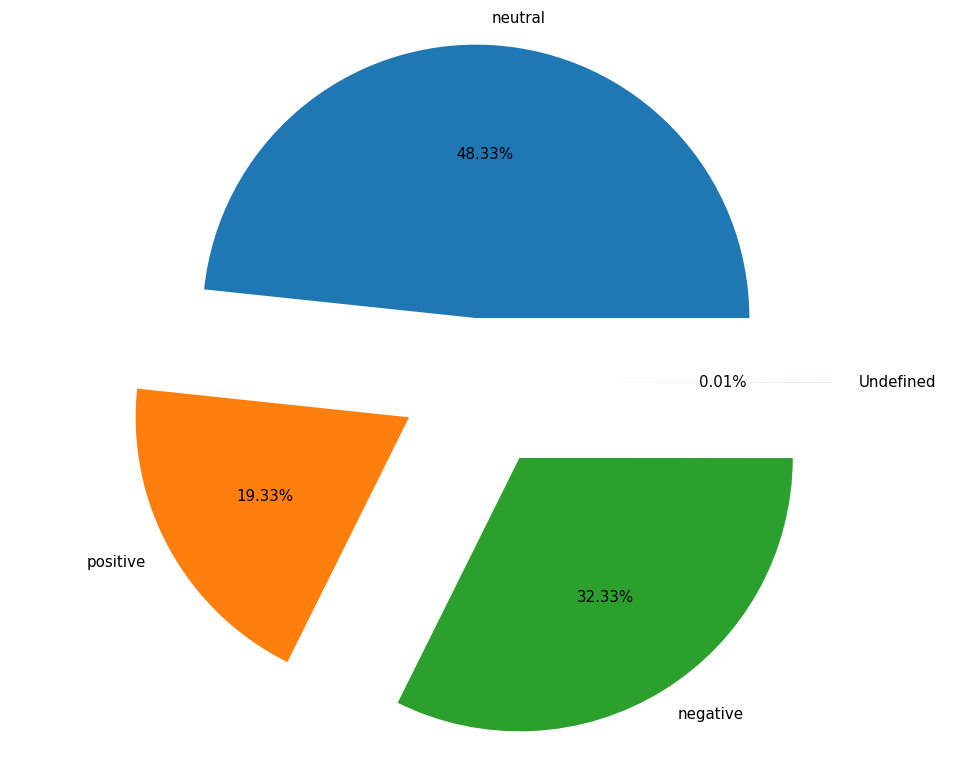

Attempting pre-processing...
101651
Showing first 100 top-freqent words in the corpus


,Word,Frequency,Counts
1,trump,0.010400,1056 times
2,like,0.004900,494 times
3,people,0.003700,373 times
4,dont,0.003500,359 times
5,im,0.003300,335 times
6,new,0.003000,305 times
7,vote,0.002700,272 times
8,time,0.002600,267 times
9,need,0.002600,266 times
10,know,0.002600,260 times


Selecting the most relevant word features using Part-of-Speach Tagging...
Done -  250 / 3000 eleapsed time - 21.067121744155884 ; estimated total time - 252.8054609298706
Done -  500 / 3000 eleapsed time - 42.16436171531677 ; estimated total time - 252.98617029190063
Done -  750 / 3000 eleapsed time - 63.11529564857483 ; estimated total time - 252.46118259429932
Done -  1000 / 3000 eleapsed time - 84.25147843360901 ; estimated total time - 252.75443530082703
Done -  1250 / 3000 eleapsed time - 105.20251941680908 ; estimated total time - 252.4860466003418
Done -  1500 / 3000 eleapsed time - 126.55868124961853 ; estimated total time - 253.11736249923706
Done -  1750 / 3000 eleapsed time - 147.64087176322937 ; estimated total time - 253.0986373083932
Done -  2000 / 3000 eleapsed time - 168.5977680683136 ; estimated total time - 252.8966521024704
Done -  2250 / 3000 eleapsed time - 189.49869585037231 ; estimated total time - 252.66492780049643
Done -  2500 / 3000 eleapsed time - 210.354640

,Word,Frequency,Counts,Part-Of-Speech Tag
1,trump,0.010400,1056 times,PROPN
2,like,0.004900,494 times,SCONJ
3,people,0.003700,373 times,NOUN
4,do,0.003500,359 times,AUX
5,i,0.003300,335 times,PRON
6,new,0.003000,305 times,PROPN
7,vote,0.002700,272 times,NOUN
8,time,0.002600,267 times,NOUN
9,need,0.002600,266 times,PROPN
10,know,0.002600,260 times,VERB


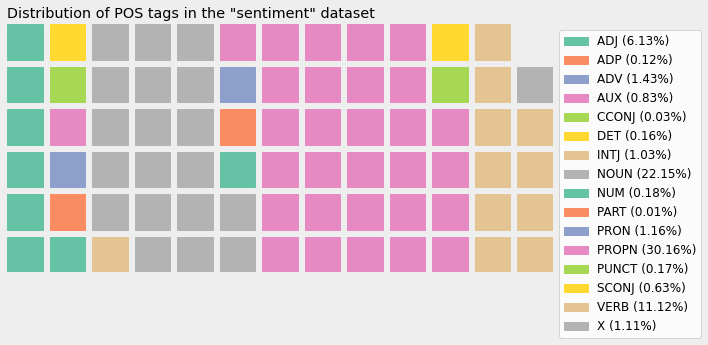

Performing emotion task
Amount of tweets in the emotion dataset - 1422

Distribution of different classes in the "emotion" dataset


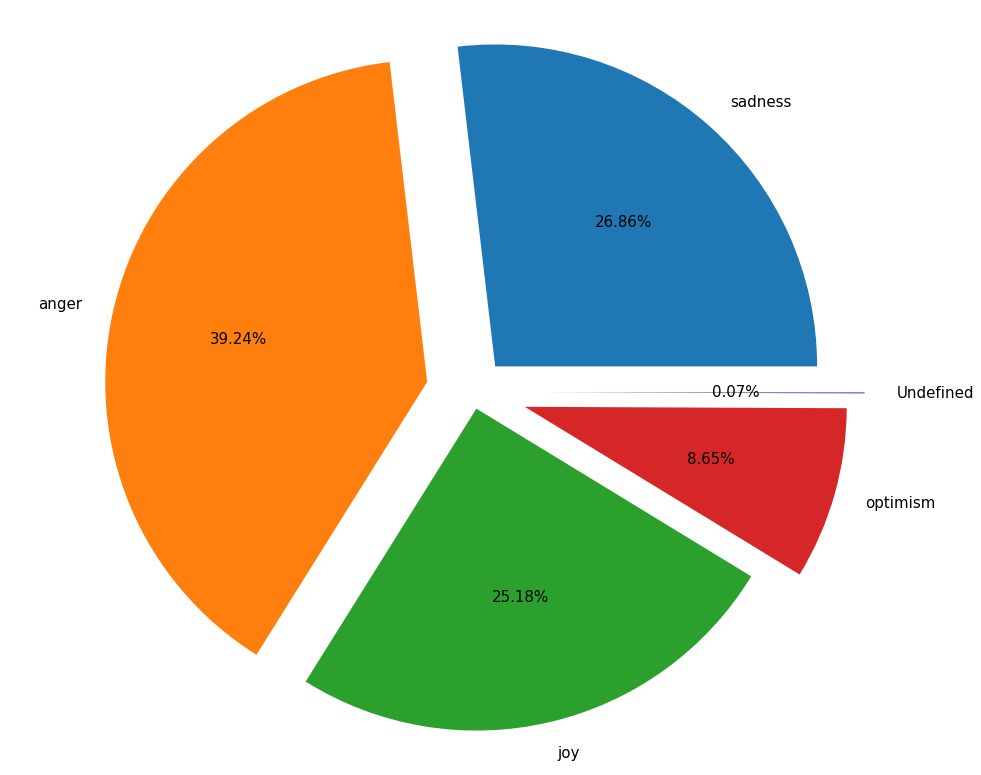

Attempting pre-processing...
11424
Showing first 100 top-freqent words in the corpus


,Word,Frequency,Counts
1,im,0.010200,116 times
2,dont,0.007500,86 times
3,like,0.006500,74 times
4,amp,0.005700,65 times
5,people,0.005400,62 times
6,love,0.005300,60 times
7,know,0.004900,56 times
8,day,0.004900,56 times
9,time,0.004700,54 times
10,u,0.004600,53 times


Selecting the most relevant word features using Part-of-Speach Tagging...
Done -  250 / 3000 eleapsed time - 20.882275342941284 ; estimated total time - 250.5873041152954
Done -  500 / 3000 eleapsed time - 41.68651604652405 ; estimated total time - 250.1190962791443
Done -  750 / 3000 eleapsed time - 62.67877411842346 ; estimated total time - 250.71509647369385
Done -  1000 / 3000 eleapsed time - 83.55335354804993 ; estimated total time - 250.66006064414978
Done -  1250 / 3000 eleapsed time - 104.39020919799805 ; estimated total time - 250.5365020751953
Done -  1500 / 3000 eleapsed time - 125.19830822944641 ; estimated total time - 250.39661645889282
Done -  1750 / 3000 eleapsed time - 145.96577429771423 ; estimated total time - 250.2270416532244
Done -  2000 / 3000 eleapsed time - 166.84731912612915 ; estimated total time - 250.27097868919373
Done -  2250 / 3000 eleapsed time - 187.66835188865662 ; estimated total time - 250.2244691848755
Done -  2500 / 3000 eleapsed time - 208.499849

,Word,Frequency,Counts,Part-Of-Speech Tag
1,i,0.010200,116 times,PRON
2,do,0.007500,86 times,AUX
3,like,0.006500,74 times,SCONJ
4,amp,0.005700,65 times,PROPN
5,people,0.005400,62 times,NOUN
6,love,0.005300,60 times,NOUN
7,know,0.004900,56 times,VERB
8,day,0.004900,56 times,NOUN
9,time,0.004700,54 times,NOUN
10,u,0.004600,53 times,X


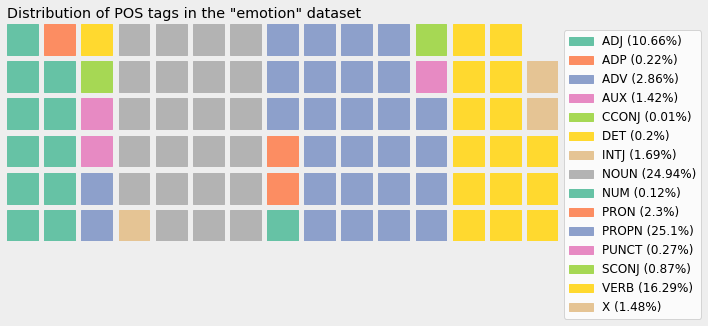

Performing emoji task
Amount of tweets in the emoji dataset - 50001
{'0': '❤', '1': '😍', '2': '😂', '3': '💕', '4': '🔥', '5': '😊', '6': '😎', '7': '✨', '8': '💙', '9': '😘', '10': '📷', '11': '🇺🇸', '12': '☀', '13': '💜', '14': '😉', '15': '💯', '16': '😁', '17': '🎄', '18': '📸', '19': '😜'}

Distribution of different classes in the "emoji" dataset


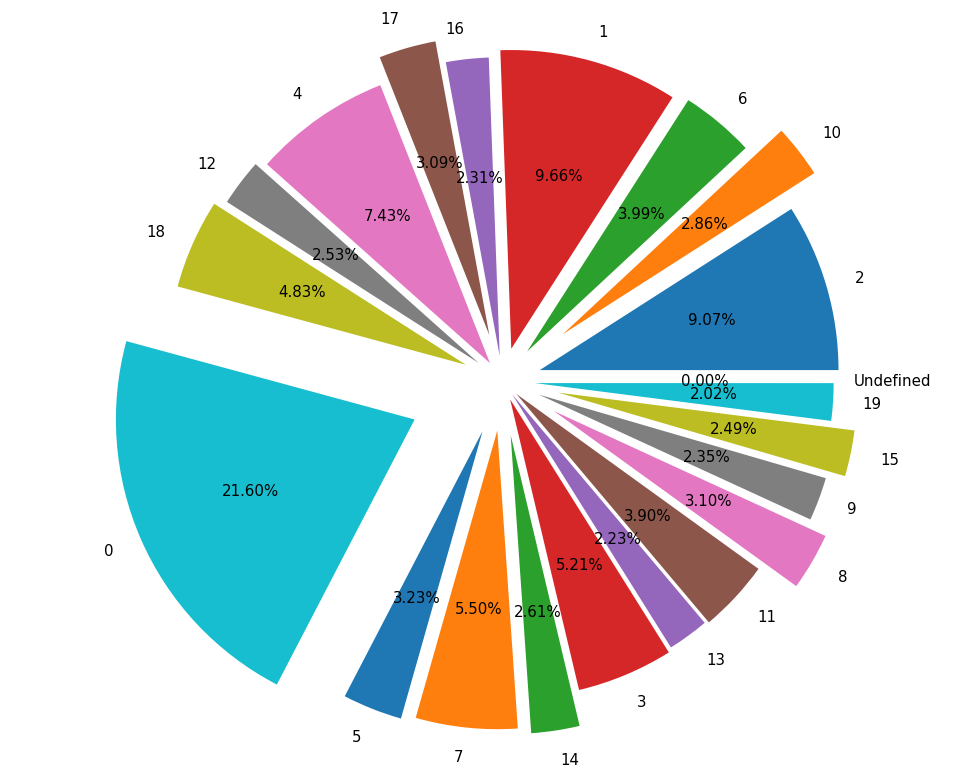

Attempting pre-processing...
355557
Showing first 100 top-freqent words in the corpus


,Word,Frequency,Counts
1,️,0.031400,11158 times
2,love,0.011500,4104 times
3,new,0.010000,3562 times
4,day,0.007200,2546 times
5,happy,0.007000,2499 times
6,amp,0.006300,2237 times
7,…,0.005100,1826 times
8,time,0.004900,1735 times
9,night,0.004200,1507 times
10,today,0.004100,1454 times


Selecting the most relevant word features using Part-of-Speach Tagging...
Done -  250 / 3000 eleapsed time - 20.913907527923584 ; estimated total time - 250.966890335083
Done -  500 / 3000 eleapsed time - 41.91312098503113 ; estimated total time - 251.47872591018677
Done -  750 / 3000 eleapsed time - 62.90943479537964 ; estimated total time - 251.63773918151855
Done -  1000 / 3000 eleapsed time - 83.7641453742981 ; estimated total time - 251.2924361228943
Done -  1250 / 3000 eleapsed time - 104.7333071231842 ; estimated total time - 251.3599370956421
Done -  1500 / 3000 eleapsed time - 125.71434354782104 ; estimated total time - 251.4286870956421
Done -  1750 / 3000 eleapsed time - 146.59941387176514 ; estimated total time - 251.31328092302596
Done -  2000 / 3000 eleapsed time - 167.54383063316345 ; estimated total time - 251.31574594974518
Done -  2250 / 3000 eleapsed time - 188.42423963546753 ; estimated total time - 251.2323195139567
Done -  2500 / 3000 eleapsed time - 209.296806097

,Word,Frequency,Counts,Part-Of-Speech Tag
1,️,0.031400,11158 times,X
2,love,0.011500,4104 times,NOUN
3,new,0.010000,3562 times,PROPN
4,day,0.007200,2546 times,NOUN
5,happy,0.007000,2499 times,ADJ
6,amp,0.006300,2237 times,PROPN
7,…,0.005100,1826 times,PUNCT
8,time,0.004900,1735 times,NOUN
9,night,0.004200,1507 times,NOUN
10,today,0.004100,1454 times,NOUN


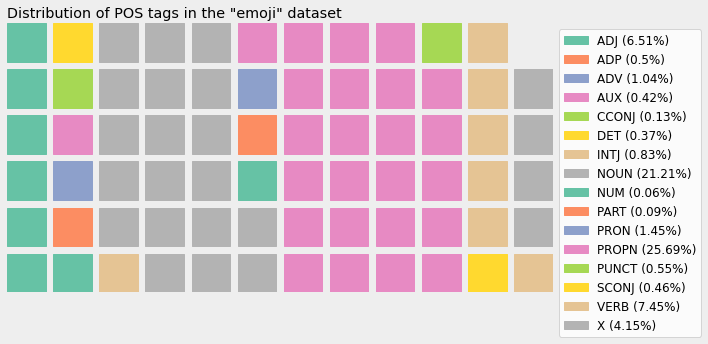

In [ ]:
tags_distribution_dict = do_data_exploration()

## 2. Demonstration of pre-processing 

In [ ]:
def do_data_exploration():
  tasks_data=load_all_data()
  for task in tasks_data.keys():
    print("Performing "+task,"task")
    # download label mapping
    X_test=tasks_data[task]["X_test"]
    Y_test=tasks_data[task]["Y_test"]
    labels=tasks_data[task]["labels"]
    metric=tasks_data[task]["metric"]

    mapping={str(key):value for key,value in enumerate(labels)}
    
    # download tweets
    print("Amount of tweets in the "+task+" dataset -",len(X_test))
      # download tweets labels
    test_labels_names=[]
    if task!="emoji":
      test_labels_names=[mapping[item] if item in mapping else "Undefined" for item in Y_test]
    else:
      print(mapping)
      test_labels_names=[item if item in mapping else "Undefined" for item in Y_test]
    c = collections.Counter(test_labels_names)
    # # Creating pie chart 
    # fig = plt.figure(figsize =(20, 15)) 
    # plt.pie(c.values(), labels = c.keys(),autopct='%3.9f%%') 

    # # show plot 
    # plt.show() 
    print()
    print("Distribution of different classes in the \""+task+"\" dataset")
    interchunk_distances = np.random.uniform(low=0.05, high=0.35, size=len(c.keys())) 
    fig1, ax1 = plt.subplots(figsize =(17, 14))
    plt.rcParams.update({'font.size':15})
    wedges, texts, autotexts = ax1.pie(c.values(), explode=interchunk_distances,labels = c.keys(), autopct='%1.2f%%')
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

    X_test = data_preprocessing(X_test, ["Removal of URL symbols", "Text normalisation", "Removal of stop-words", "Text lemmatisation"])
    freq_words_data=select_best_keywords(X_test, 3000)
    keywords_processor=POS_word_feature_selector(freq_words_data, ['ADJ', 'VERB', 'ADV'], task)
  return keywords_processor

In [ ]:
def demonstrate_preprocessing():
  tasks_data=load_all_data()
  print()
  print()
  print()
  for task in tasks_data.keys():
    print("<===================================================>")
    print("<===================================================>")
    print()
    print("[Performing "+task,"task]")
    print()
    # download label mapping
    X_test=tasks_data[task]["X_test"]
    Y_test=tasks_data[task]["Y_test"]
    labels=tasks_data[task]["labels"]
    mapping={str(key):value for key,value in enumerate(labels)}
      
    # download tweets labels
    test_labels_names=[]
    experiments=[["Removal of URL symbols", "Text normalisation", "Removal of stop-words", "Text lemmatisation"],
                ["Removal of URL symbols", "Text normalisation", "Removal of stop-words"],
                ["Removal of URL symbols", "Text normalisation"],
                ["Removal of URL symbols"],
                []]
    number_of_tweets=1
    X_sample=X_test[:number_of_tweets]
    for experiment in experiments:
      print(" Performing an experiment with a preprocessing pipeline that includes the following steps:")
      print()
      print(experiment)
      print()
      print()

      X_test_prep = data_preprocessing(X_test, experiment)
      X_sample_prep=X_test_prep[:number_of_tweets]
      for index in range(0,number_of_tweets):
        # print(str(index+1)+".")
        print()
        print("   [Original tweet]:")
        print(X_sample[index])
        print()
        print("   [Processed tweet]:")
        print(X_sample_prep[index])
        print()
        print("   [List of tokens]:")
        print(X_sample_prep[index].split())
        print()
      print("<===================================================>")


In [ ]:
demonstrate_preprocessing()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model 




<===================================================>
<===================================================>

[Performing sentiment task]

 Performing an experiment with a preprocessing pipeline that includes the following steps:

['Removal of URL symbols', 'Text normalisation', 'Removal of stop-words', 'Text lemmatisation']


Attempting pre-processing...

   [Original tweet]:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 

   [Processed tweet]:
naked pic like

   [List of tokens]:
['naked', 'pic', 'like']

<===================================================>
 Performing an experiment with a preprocessing pipeline that includes the following steps:

['Removal of URL symbols', 'Text normalisation', 'Removal of stop-words']


Attempting pre-processing...

   [Original tweet]:
@user @user what do these '1/2 naked pics' have to do with anything? They're not even like that. 

   [Processed tweet]:
naked pics like

   [List of tokens]:
['

In [ ]:
# https://medium.com/analytics-vidhya/hugging-face-transformers-how-to-use-pipelines-10775aa3db7e
# https://tomaxent.com/2018/04/27/Micro-and-Macro-average-of-Precision-Recall-and-F-Score/